In [1]:
#import random
import torch as tc
import numpy as np
import qutip as qt
import function as my
import matplotlib.pyplot as plt
import random
from tqdm import tqdm


In [2]:

def data_qubit_two_crosstalk(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    IX,IY,IZ = qt.tensor(qt.qeye(2) ,qt.sigmax()),qt.tensor(qt.qeye(2),qt.sigmay() ),qt.tensor(qt.qeye(2) ,qt.sigmaz())
    XI,YI,ZI = qt.tensor(qt.sigmax(),qt.qeye(2) ),qt.tensor(qt.sigmay(),qt.qeye(2) ),qt.tensor(qt.sigmaz(),qt.qeye(2) )
    XX,XY,XZ = qt.tensor(qt.sigmax(),qt.sigmax()),qt.tensor(qt.sigmax(),qt.sigmay()),qt.tensor(qt.sigmax(),qt.sigmaz())
    YX,YY,YZ = qt.tensor(qt.sigmay(),qt.sigmax()),qt.tensor(qt.sigmay(),qt.sigmay()),qt.tensor(qt.sigmay(),qt.sigmaz())
    ZX,ZY,ZZ = qt.tensor(qt.sigmaz(),qt.sigmax()),qt.tensor(qt.sigmaz(),qt.sigmay()),qt.tensor(qt.sigmaz(),qt.sigmaz())
    operadores = [IX,IY,IZ,
                  XI,YI,ZI,
                  XX,XY,XZ,
                  YX,YY,YZ,
                  ZX,ZY,ZZ]
    
    H = 0
    for i in range(len(lista_J)):
        H += 0.5*lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.tensor(qt.sigmam(), qt.qeye(2)),
             np.sqrt(dissipation[1])*qt.tensor(qt.sigmaz(), qt.qeye(2)),
             np.sqrt(dissipation[2])*qt.tensor(qt.qeye(2) , qt.sigmam()),
             np.sqrt(dissipation[3])*qt.tensor(qt.qeye(2) , qt.sigmaz()),]
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # |+> = (|0> + |1>)/sqrt(2)
    theta1  = np.pi/4
    phi1    = 0.0 #np.pi/3
    ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))
    theta2  = np.pi/4
    phi2    = 0.0 #np.pi/5
    ket_plus2 = (np.cos(theta2)*qt.basis(2, 0)+np.sin(theta2)*np.exp(1j*phi2)*qt.basis(2, 1))

    psi0 = qt.tensor(ket_plus1, ket_plus2)
    
    # Lista de tempos para a evolução
    tlist = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect

O_op =[ qt.tensor(qt.qeye(2) , qt.sigmax()),
        qt.tensor(qt.qeye(2) , qt.sigmay()),
        qt.tensor(qt.qeye(2) , qt.sigmaz()),
        qt.tensor(qt.sigmax(), qt.qeye(2) ),
        qt.tensor(qt.sigmax(), qt.sigmax()),
        qt.tensor(qt.sigmax(), qt.sigmay()),
        qt.tensor(qt.sigmax(), qt.sigmaz()),
        qt.tensor(qt.sigmay(), qt.qeye(2) ),
        qt.tensor(qt.sigmay(), qt.sigmax()),
        qt.tensor(qt.sigmay(), qt.sigmay()),
        qt.tensor(qt.sigmay(), qt.sigmaz()),
        qt.tensor(qt.sigmaz(), qt.qeye(2) ),
        qt.tensor(qt.sigmaz(), qt.sigmax()),
        qt.tensor(qt.sigmaz(), qt.sigmay()),
        qt.tensor(qt.sigmaz(), qt.sigmaz()),
        ]


In [3]:
SEED =15

c:\Users\Gubio\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


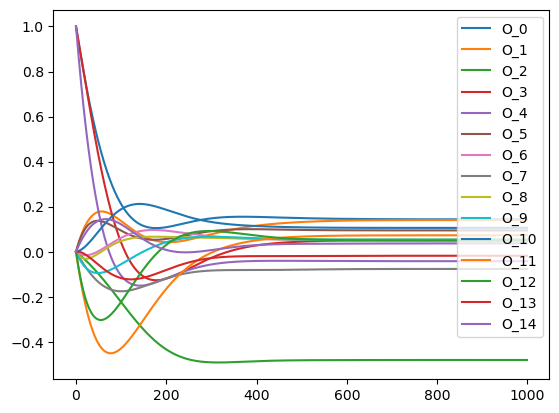

[ 0.93048428 -0.97669061  0.47198324 -0.68397455  0.9726789  -0.96623869
  0.75898254  0.36270133  0.71468476  0.99963247 -0.52056964 -0.32384449
  0.41638867 -0.43883663 -0.47337149] [0.22860973 0.8578371  0.87453261 0.79761599]


In [4]:
# Definindo a seed
np.random.seed(SEED)
tc.manual_seed(SEED) 
random.seed(SEED)

# Js          = np.random.uniform(-1,1,15)
# dissipation = np.random.rand(4)
Js          = [random.uniform(-1,1) for _ in range(15)]
dissipation = [random.uniform(0,1) for _ in range(4)]


tfinal      = 2*np.pi
N           = 1000

valor_esperado_data  = data_qubit_two_crosstalk(np.array(Js),np.array(dissipation),tfinal,N,O_op,device="cpu")

for i in range(len(O_op)):
    plt.plot(valor_esperado_data[:,i].cpu() ,label=f"O_{i}")

plt.legend()
plt.show()
print(np.array(Js),np.array(dissipation))

In [5]:
# parametro_treino = {
#     'gamma1': [dissipation[0]],
#     'gamma2': [dissipation[1]],
#     'gamma3': [dissipation[2]],
#     'gamma4': [dissipation[3]],
#     'JXX': [Js[6]],
#     'JXY': [Js[7]],
#     'JXZ': [Js[2]],
#     'JYX': [Js[3]],
#     'JYY': [Js[4]],
#     'JYZ': [Js[5]],
#     'JZX': [Js[6]],
#     'JZY': [Js[7]],
#     'JZZ': [Js[8]],
#     'JIX': [Js[0]],
#     'JIY': [Js[1]],
#     'JIZ': [Js[2]],
#     'JXI': [Js[3]],
#     'JYI': [Js[4]],
#     'JZI': [Js[5]],}

# import pandas as pd
# data = {'treino': parametro_treino}
# df = pd.DataFrame(data)
# df.to_csv(f"parametro.csv")

In [6]:
# Definindo a seed
np.random.seed(SEED)
tc.manual_seed(SEED) 
random.seed(SEED)

neuronio = [50,50]
X_vector   = my.Rede(
    neuronio    = neuronio,
    input_      = 1,
    output_     = len(O_op),
    activation  =[tc.nn.Tanh()]*len(neuronio),
    creat_p     =True,
    N_of_paramater= 15 +4)
opt = tc.optim.Adam(X_vector.parameters(),
        lr = 0.001 )
time =  tc.linspace(
        0,
        tfinal,
        N,
        dtype   = tc.float32,
        requires_grad = True).reshape((-1, 1))
index_data = np.random.randint(0,N,size=5)
X_vector.parametro

Parameter containing:
tensor([0.2572, 0.3794, 0.4638, 0.1350, 0.9673, 0.9803, 0.6377, 0.9757, 0.4102,
        0.7087, 0.3689, 0.6160, 0.0589, 0.6305, 0.7323, 0.4852, 0.7174, 0.4119,
        0.9809], requires_grad=True)

In [7]:
# Definindo a seed
np.random.seed(SEED)
tc.manual_seed(SEED) 
random.seed(SEED)

epocas  = 50000
LOSS    = []
LOSS1   = []
LOSS2   = []
hisorty_of_param = []
bestloss = 1e10
for _ in tqdm(range(epocas)):
    ####### Forward pass #######
    y  = X_vector(time)     
    
    ######## Los edo #######
    dX_dt = []
    for i in range(y.shape[1]):
        dX_dt.append(tc.autograd.grad(outputs = y[:, i], 
                                    inputs = time,
                                    grad_outputs = tc.ones_like(y[:, i]),
                                    #retain_graph = True,
                                    create_graph = True)[0])
    dX_dt   = tc.cat(dX_dt, dim=1)
    
    IX,IY,IZ,XI,XX,XY,XZ = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4],y[:, 4:5], y[:, 5:6],y[:, 6:7]
    YI,YX,YY,YZ,ZI,ZX,ZY,ZZ = y[:, 7:8], y[:, 8:9], y[:, 9:10],y[:, 10:11], y[:, 11:12], y[:,12:13], y[:,13:14], y[:,14:15]

    JIX,JIY,JIZ,JXI,JYI,JZI,JXX,JXY,JXZ,JYX,JYY,JYZ,JZX,JZY,JZZ,gamma1,gamma2,gamma3,gamma4 = X_vector.parametro
    
    LOSS_edo  = 0
    LOSS_edo += (dX_dt[:,0:1] - ( +IX*(-0.5*gamma3 - 2.0*gamma4) +IY*(-1.0*JIZ) +IZ*(1.0*JIY) +(-1.0*JXZ)*XY +JXY*XZ +(-1.0*JYZ)*YY +(1.0*JYY)*YZ +(-1.0*JZZ)*ZY +(1.0*JZY)*ZZ))**2
    LOSS_edo += (dX_dt[:,1:2] - ( +IX*(1.0*JIZ) +IY*(-0.5*gamma3 - 2.0*gamma4) +IZ*(-1.0*JIX) +(1.0*JXZ)*XX +(-1.0*JXX)*XZ +JYZ*YX +(-1.0*JYX)*YZ +(1.0*JZZ)*ZX +(-1.0*JZX)*ZZ))**2
    LOSS_edo += (dX_dt[:,2:3] - ( (-1.0*gamma3) +IX*(-1.0*JIY) +IY*(1.0*JIX) +IZ*(-1.0*gamma3) +(-1.0*JXY)*XX +(1.0*JXX)*XY +(-1.0*JYY)*YX +JYX*YY +(-1.0*JZY)*ZX +(1.0*JZX)*ZY))**2
    LOSS_edo += (dX_dt[:,3:4] - ( +XI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JZI)*YI +(-1.0*JZX)*YX +(-1.0*JZY)*YY +(-1.0*JZZ)*YZ +(1.0*JYI)*ZI +JYX*ZX +(1.0*JYY)*ZY +(1.0*JYZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,4:5] - ( +IY*(-1.0*JXZ) +IZ*(1.0*JXY) +XX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIZ)*XY +JIY*XZ +(-1.0*JZX)*YI +(-1.0*JZI)*YX +(1.0*JYX)*ZI +JYI*ZX))**2
    LOSS_edo += (dX_dt[:,5:6] - ( +IX*(1.0*JXZ) +IZ*(-1.0*JXX) +(1.0*JIZ)*XX +XY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIX)*XZ +(-1.0*JZY)*YI +(-1.0*JZI)*YY +(1.0*JYY)*ZI +JYI*ZY))**2
    LOSS_edo += (dX_dt[:,6:7] - ( +IX*(-1.0*JXY) +IY*(1.0*JXX) +XI*(-1.0*gamma3) +(-1.0*JIY)*XX +(1.0*JIX)*XY +XZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-1.0*JZZ)*YI +(-1.0*JZI)*YZ +(1.0*JYZ)*ZI +(1.0*JYI)*ZZ))**2
    LOSS_edo += (dX_dt[:,7:8] - ( +(1.0*JZI)*XI +(1.0*JZX)*XX +JZY*XY +(1.0*JZZ)*XZ +YI*(-0.5*gamma1 - 2.0*gamma2) +(-1.0*JXI)*ZI +(-1.0*JXX)*ZX +(-1.0*JXY)*ZY +(-1.0*JXZ)*ZZ))**2
    LOSS_edo += (dX_dt[:,8:9] - ( +IY*(-1.0*JYZ) +IZ*(1.0*JYY) +(1.0*JZX)*XI +(1.0*JZI)*XX +YX*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIZ)*YY +JIY*YZ +(-1.0*JXX)*ZI +(-1.0*JXI)*ZX))**2
    LOSS_edo += (dX_dt[:,9:10] - ( +IX*JYZ +IZ*(-1.0*JYX) +JZY*XI +(1.0*JZI)*XY +(1.0*JIZ)*YX +YY*(-0.5*gamma1 - 2.0*gamma2 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIX)*YZ +(-1.0*JXY)*ZI +(-1.0*JXI)*ZY))**2
    LOSS_edo += (dX_dt[:,10:11] - ( +IX*(-1.0*JYY) +IY*JYX +(1.0*JZZ)*XI +(1.0*JZI)*XZ +YI*(-1.0*gamma3) +(-1.0*JIY)*YX +(1.0*JIX)*YY +YZ*(-0.5*gamma1 - 2.0*gamma2 - 1.0*gamma3) +(-1.0*JXZ)*ZI +(-1.0*JXI)*ZZ))**2
    LOSS_edo += (dX_dt[:,11:12] - ( (-1.0*gamma1) +(-1.0*JYI)*XI +(-1.0*JYX)*XX +(-1.0*JYY)*XY +(-1.0*JYZ)*XZ +(1.0*JXI)*YI +(1.0*JXX)*YX +JXY*YY +(1.0*JXZ)*YZ +ZI*(-1.0*gamma1)))**2
    LOSS_edo += (dX_dt[:,12:13] - ( +IX*(-1.0*gamma1) +IY*(-1.0*JZZ) +IZ*(1.0*JZY) +(-1.0*JYX)*XI +(-1.0*JYI)*XX +(1.0*JXX)*YI +(1.0*JXI)*YX +ZX*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIZ)*ZY +(1.0*JIY)*ZZ))**2
    LOSS_edo += (dX_dt[:,13:14] - ( +IX*(1.0*JZZ) +IY*(-1.0*gamma1) +IZ*(-1.0*JZX) +(-1.0*JYY)*XI +(-1.0*JYI)*XY +JXY*YI +(1.0*JXI)*YY +(1.0*JIZ)*ZX +ZY*(-1.0*gamma1 - 0.5*gamma3 - 2.0*gamma4) +(-1.0*JIX)*ZZ))**2
    LOSS_edo += (dX_dt[:,14:15] - ( +IX*(-1.0*JZY) +IY*(1.0*JZX) +IZ*(-1.0*gamma1) +(-1.0*JYZ)*XI +(-1.0*JYI)*XZ +(1.0*JXZ)*YI +(1.0*JXI)*YZ +ZI*(-1.0*gamma3) +(-1.0*JIY)*ZX +(1.0*JIX)*ZY +ZZ*(-1.0*gamma1 - 1.0*gamma3)))**2
    LOSS_edo = LOSS_edo.mean() 
    ####### loss data(expected values) #######
    LOSS_data = tc.mean((y[index_data,:]  - valor_esperado_data[index_data,:])**2) 
    
    ####### Loss total #######
    loss_i = LOSS_edo*0.01 + LOSS_data
    
    if loss_i< bestloss:
        bestloss=  loss_i.item()
        best_param = [X_vector.parametro.detach().cpu().numpy()]
    ####### Backpropagation #######
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    LOSS1.append(LOSS_edo.cpu().detach().numpy())
    LOSS2.append(LOSS_data.cpu().detach().numpy())
    LOSS.append(loss_i.cpu().detach().numpy())

100%|██████████| 50000/50000 [20:10<00:00, 41.29it/s]  


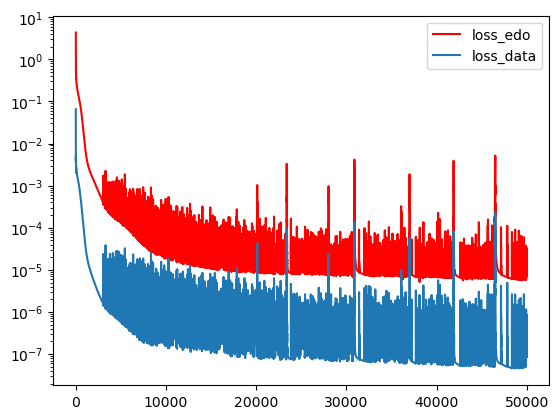

Valor final: Parameter containing:
tensor([ 0.4398, -0.4246,  0.1367, -0.2092,  0.4513, -0.3686,  0.3485,  0.1701,
         0.3372,  0.4422, -0.2534, -0.1180,  0.1750, -0.1930, -0.1736,  0.0961,
         0.4029,  0.3971,  0.3608], requires_grad=True)


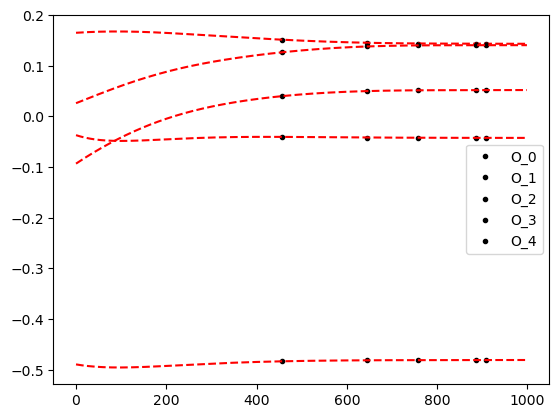

In [8]:
#plt.plot(LOSS,"k.",label="loss_total")
plt.plot(LOSS1,'r-',label="loss_edo")
plt.plot(LOSS2,label="loss_data")
plt.yscale("log")
plt.legend()
plt.show()
print("Valor final:",X_vector.parametro)


X_vector.eval()
X_  = X_vector(time).detach().numpy()

for i in range(5):
    plt.plot(index_data,valor_esperado_data[index_data,i].cpu(),"k." ,label=f"O_{i}")
    plt.plot(X_[:,i],"r--")

# plt.plot(X_[:,3],"--",label="sigmaI_Y")

plt.legend()
plt.show()

In [9]:
X_vector.parametro

Parameter containing:
tensor([ 0.4398, -0.4246,  0.1367, -0.2092,  0.4513, -0.3686,  0.3485,  0.1701,
         0.3372,  0.4422, -0.2534, -0.1180,  0.1750, -0.1930, -0.1736,  0.0961,
         0.4029,  0.3971,  0.3608], requires_grad=True)

In [13]:
best_param

[array([ 0.4398153 , -0.4246261 ,  0.13667765, -0.20923819,  0.45131448,
        -0.36862278,  0.3484579 ,  0.17006789,  0.3372147 ,  0.44216734,
        -0.25338534, -0.11804132,  0.17503613, -0.1929545 , -0.17361987,
         0.09605528,  0.40293175,  0.39711228,  0.36082846], dtype=float32)]

In [10]:
tc.tensor(Js + dissipation)

tensor([ 0.9305, -0.9767,  0.4720, -0.6840,  0.9727, -0.9662,  0.7590,  0.3627,
         0.7147,  0.9996, -0.5206, -0.3238,  0.4164, -0.4388, -0.4734,  0.2286,
         0.8578,  0.8745,  0.7976])

In [11]:
abs(X_vector.parametro - tc.tensor(Js + dissipation))

tensor([0.4907, 0.5521, 0.3353, 0.4747, 0.5214, 0.5976, 0.4105, 0.1926, 0.3775,
        0.5575, 0.2672, 0.2058, 0.2414, 0.2459, 0.2998, 0.1326, 0.4549, 0.4774,
        0.4368], grad_fn=<AbsBackward0>)

In [12]:
import pandas as pd
parametro_treino = {
    'gamma1': [dissipation[0]],
    'gamma2': [dissipation[1]],
    'gamma3': [dissipation[2]],
    'gamma4': [dissipation[3]],
    'JXX': [Js[6]],
    'JXY': [Js[7]],
    'JXZ': [Js[2]],
    'JYX': [Js[3]],
    'JYY': [Js[4]],
    'JYZ': [Js[5]],
    'JZX': [Js[6]],
    'JZY': [Js[7]],
    'JZZ': [Js[8]],
    'JIX': [Js[0]],
    'JIY': [Js[1]],
    'JIZ': [Js[2]],
    'JXI': [Js[3]],
    'JYI': [Js[4]],
    'JZI': [Js[5]],}

parametro_previsto = {
    'gamma1': [X_vector.parametro[15].item()],
    'gamma2': [X_vector.parametro[16].item()],
    'gamma3': [X_vector.parametro[17].item()],
    'gamma4': [X_vector.parametro[18].item()],
    'JXX': [X_vector.parametro[6].item()],
    'JXY': [X_vector.parametro[7].item()],
    'JXZ': [X_vector.parametro[8].item()],
    'JYX': [X_vector.parametro[9].item()],
    'JYY': [X_vector.parametro[10].item()],
    'JYZ': [X_vector.parametro[11].item()],
    'JZX': [X_vector.parametro[12].item()],
    'JZY': [X_vector.parametro[13].item()],
    'JZZ': [X_vector.parametro[14].item()],
    'JIX': [X_vector.parametro[0].item()],
    'JIY': [X_vector.parametro[1].item()],
    'JIZ': [X_vector.parametro[2].item()],
    'JXI': [X_vector.parametro[3].item()],
    'JYI': [X_vector.parametro[4].item()],
    'JZI': [X_vector.parametro[5].item()],
    }

data = {'treino': parametro_treino, 'previsto': parametro_previsto}
df = pd.DataFrame(data)
df

,treino,previsto
gamma1,[0.22860972534891622],[0.0960552766919136]
gamma2,[0.8578370973942192],[0.40293174982070923]
gamma3,[0.8745326053736207],[0.39711228013038635]
gamma4,[0.7976159923774808],[0.3608284592628479]
JXX,[0.7589825362693423],[0.3484579026699066]
JXY,[0.3627013288028291],[0.1700678914785385]
JXZ,[0.4719832395937509],[0.33721470832824707]
JYX,[-0.6839745504705037],[0.44216734170913696]
JYY,[0.9726789033256467],[-0.2533853352069855]
JYZ,[-0.9662386915840475],[-0.11804132163524628]


In [14]:
best_param[0]

array([ 0.4398153 , -0.4246261 ,  0.13667765, -0.20923819,  0.45131448,
       -0.36862278,  0.3484579 ,  0.17006789,  0.3372147 ,  0.44216734,
       -0.25338534, -0.11804132,  0.17503613, -0.1929545 , -0.17361987,
        0.09605528,  0.40293175,  0.39711228,  0.36082846], dtype=float32)

In [15]:
import pandas as pd
parametro_treino = {
    'gamma1': [dissipation[0]],
    'gamma2': [dissipation[1]],
    'gamma3': [dissipation[2]],
    'gamma4': [dissipation[3]],
    'JXX': [Js[6]],
    'JXY': [Js[7]],
    'JXZ': [Js[2]],
    'JYX': [Js[3]],
    'JYY': [Js[4]],
    'JYZ': [Js[5]],
    'JZX': [Js[6]],
    'JZY': [Js[7]],
    'JZZ': [Js[8]],
    'JIX': [Js[0]],
    'JIY': [Js[1]],
    'JIZ': [Js[2]],
    'JXI': [Js[3]],
    'JYI': [Js[4]],
    'JZI': [Js[5]],}

parametro_previsto = {
    'gamma1': [best_param[0][15].item()],
    'gamma2': [best_param[0][16].item()],
    'gamma3': [best_param[0][17].item()],
    'gamma4': [best_param[0][18].item()],
    'JXX': [best_param[0][6].item()],
    'JXY': [best_param[0][7].item()],
    'JXZ': [best_param[0][8].item()],
    'JYX': [best_param[0][9].item()],
    'JYY': [best_param[0][10].item()],
    'JYZ': [best_param[0][11].item()],
    'JZX': [best_param[0][12].item()],
    'JZY': [best_param[0][13].item()],
    'JZZ': [best_param[0][14].item()],
    'JIX': [best_param[0][0].item()],
    'JIY': [best_param[0][1].item()],
    'JIZ': [best_param[0][2].item()],
    'JXI': [best_param[0][3].item()],
    'JYI': [best_param[0][4].item()],
    'JZI': [best_param[0][5].item()],
    }

data = {'treino': parametro_treino, 'previsto': parametro_previsto}
df = pd.DataFrame(data)
df

,treino,previsto
gamma1,[0.22860972534891622],[0.0960552766919136]
gamma2,[0.8578370973942192],[0.40293174982070923]
gamma3,[0.8745326053736207],[0.39711228013038635]
gamma4,[0.7976159923774808],[0.3608284592628479]
JXX,[0.7589825362693423],[0.3484579026699066]
JXY,[0.3627013288028291],[0.1700678914785385]
JXZ,[0.4719832395937509],[0.33721470832824707]
JYX,[-0.6839745504705037],[0.44216734170913696]
JYY,[0.9726789033256467],[-0.2533853352069855]
JYZ,[-0.9662386915840475],[-0.11804132163524628]
